# An Introduction to Linear Learner with MNIST
## Making a Binary Prediction of Whether a Handwritten Digit is a 0

This an example to use Amazon Sagemaker. SageMaker allows one to build a ML pipeline easily. Building, training and deploying of ML models is less cumbersome with SageMaker

In this example, I will be using a Amazon's marketplace algorithm (Linear Learner).
The purpose of the notebook is to explain the usage of sagemaker and not the modeling aspect.The data used in this is mnist and problem is framed as binary classification.


Amazon SageMaker's Linear Learner algorithm extends upon typical linear models by training many models in parallel, in a computationally efficient manner. Each model has a different set of hyperparameters, and then the algorithm finds the set that optimizes a specific criteria. This can provide substantially more accurate models than typical linear algorithms at the same, or lower, cost.

## Libraries used

In [20]:
import boto3
import re
import pickle 
import gzip
import numpy as np 
import urllib.request
import json
import os
import io
import sagemaker
from sagemaker.amazon.amazon_estimator import get_image_uri
import sagemaker.amazon.common as smac
from sagemaker import get_execution_role
import matplotlib.pyplot as plt
%matplotlib inline


This notebook assumes that you have an AWS account and an IAM user setup and using the notebook instance of Amazon SageMaker. For further reference please refer to this notebook https://docs.aws.amazon.com/sagemaker/latest/dg/notebooks.html

## Permissions and environment variables


This notebook was created and tested on an ml.t2.medium notebook instance.

Let's start by specifying:

1. The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
2. The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. 

In [4]:
bucket = 'test-karan-02'
prefix = 'sagemaker_demo'
role = get_execution_role()

## Data ingestion

Next, we read the dataset from an online URL into memory, for preprocessing prior to training. This processing could be done in situ by Amazon Athena, Apache Spark in Amazon EMR, Amazon Redshift, etc., assuming the dataset is present in the appropriate location. Then, the next step would be to transfer the data to S3 for use in training.

In [9]:
%%time

# Load the dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

CPU times: user 873 ms, sys: 314 ms, total: 1.19 s
Wall time: 2.74 s


## Data inspection

Once the dataset is imported, it's typical as part of the machine learning process to inspect the data, understand the distributions, and determine what type(s) of preprocessing might be needed. As an example, let's go ahead and look at one of the digits that is part of the dataset.

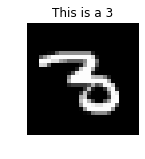

In [12]:
plt.rcParams["figure.figsize"] = (2,10)
def show_digit(img, caption='', subplot=None):
    if subplot==None:
        _,(subplot)=plt.subplots(1,1)
    imgr=img.reshape((28,28))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)

show_digit(train_set[0][30], 'This is a {}'.format(train_set[1][30]))

## Data conversion

Since algorithms have particular input and output requirements, converting the dataset is also part of the process that a data scientist goes through prior to initiating training. In this particular case, the Amazon SageMaker implementation of Linear Learner takes recordIO-wrapped protobuf, where the data we have today is a pickle-ized numpy array on disk.

Most of the conversion effort is handled by the Amazon SageMaker Python SDK, imported as sagemaker below

In [15]:
vectors = np.array([t.tolist() for t in train_set[0]]).astype('float32')
labels = np.where(np.array([t.tolist() for t in train_set[1]]) == 0, 1, 0).astype('float32')

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, vectors, labels)
buf.seek(0)

0

## Upload training data


Now that we've created our recordIO-wrapped protobuf, we'll need to upload it to S3, so that Amazon SageMaker training can use it.

In [16]:
key = 'recordio-pb-data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://test-karan-02/sagemaker_demo/recordio-pb-data


Let's also setup an output S3 location for the model artifact that will be output as the result of training with the algorithm.

In [17]:
output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))

training artifacts will be uploaded to: s3://test-karan-02/sagemaker_demo/output


## Training the linear model

Once we have the data preprocessed and available in the correct format for training, the next step is to actually train the model using the data. 

Again, we'll use the Amazon SageMaker Python SDK to kick off training, and monitor status until it is completed. . Despite the dataset being small, provisioning hardware and loading the algorithm container take time upfront.

In [19]:
container = get_image_uri(boto3.Session().region_name, 'linear-learner')

Next we'll kick off the base estimator, making sure to pass in the necessary hyperparameters. Notice:

1. feature_dim is set to 784, which is the number of pixels in each 28 x 28 image.
2. predictor_type is set to 'binary_classifier' since we are trying to predict whether the image is or is not a 0.
3. mini_batch_size is set to 200. This value can be tuned for relatively minor improvements in fit and speed, but selecting a reasonable value relative to the dataset is appropriate in most cases.

In [ ]:
sess = sagemaker.Session()
linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path=output_location,
                                       sagemaker_session=sess)
linear.set_hyperparameters(feature_dim=784,
                           predictor_type='binary_classifier',
                           mini_batch_size=200)

linear.fit({'train': s3_train_data})

##Sample Output 

1. 2020-02-26 21:07:45 Starting - Starting the training job...
2. 2020-02-26 21:07:46 Starting - Launching requested ML instances......
3. 2020-02-26 21:08:53 Starting - Preparing the instances for training......
4. 2020-02-26 21:09:48 Downloading - Downloading input data...
5. 2020-02-26 21:10:45 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train

6. 2020-02-26 21:28:11 Uploading - Uploading generated training model
7. 2020-02-26 21:28:11 Completed - Training job completed


Training seconds: 1103
Billable seconds: 1103

## Set up hosting for the model


Now that we've trained our model, we can deploy it behind an Amazon SageMaker real-time hosted endpoint. This will allow out to make predictions (or inference) from the model dyanamically.



In [ ]:
linear_predictor = linear.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')


Validate the model for use
Finally, we can now validate the model for use. We can pass HTTP POST requests to the endpoint to get back predictions. To make this easier, we'll again use the Amazon SageMaker Python SDK and specify how to serialize requests and deserialize responses that are specific to the algorithm.